In [1]:
# %load imports.py
%load_ext autoreload
%autoreload


In [2]:
import brian2 as br
from brian2.units import *
import numpy as np

In [3]:
import warnings 
def set_parameters_from_dict(neurongroup, dictionary_of_parameters):
    for param_key, param_value in dictionary_of_parameters.items():
        try: 
            neurongroup.__setattr__(param_key, param_value)
        except AttributeError as err:
            warnings.warn("{:s} has no paramater {:s}".format(neurongroup.name, param_key))

# A simple winner-takes-it-all network

- show that two excitatory LIF neurons coupled via a common interneuron can compete and implement a kind of winner-takes-it-all network, where the neuron with more input suppresses its competitor
- implement a simple network in brian2 as a preparatory step to build the spatial network
- show $I_1-I_2$ and $r_1-r2$, should be non-linear

In [4]:
lif_model_eqs = """
dv/dt =1.0/tau* (-v + u_ext) :volt (unless refractory)
tau :second
u_ext : volt
v_threshold: volt
v_reset: volt
tau_refractory: second
"""

delta_synapse_model = 'w: volt'
delta_synapse = 'v+=w'

threshold = "v>v_threshold"
reset = "v=v_reset"
refractory = "tau_refractory"

excitatory_neuron_properties = {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.5*ms
}

inhibitory_neuron_properties = {
    "tau": 7*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms
}

duration = 1000*ms


In [23]:
in_ex_connectivity=np.array([[1, 1], [0,1]]) #a one indicates a connection

In [5]:
excitatory_neurons = br.NeuronGroup(N=2, \
                                    name='excitatory_neurons',\
                                    model=lif_model_eqs, \
                                   threshold=threshold, \
                                   reset=reset,\
                                   refractory = refractory)

set_parameters_from_dict(excitatory_neurons, excitatory_neuron_properties)
excitatory_neurons.v = excitatory_neuron_properties["v_reset"]

inhibitory_neurons = br.NeuronGroup(N=1, \
                                    name='inhibitory_neurons',\
                                    model=lif_model_eqs, \
                                   threshold=threshold, \
                                   reset=reset,\
                                   refractory = refractory)

set_parameters_from_dict(inhibitory_neurons, inhibitory_neuron_properties)
inhibitory_neurons.v = inhibitory_neuron_properties["v_reset"]

excitatory_spike_recorder = br.SpikeMonitor(source=excitatory_neurons)
inhibitory_spike_recorder = br.SpikeMonitor(source=inhibitory_neurons)

ex_in_synapses = br.Synapses(source=excitatory_neurons, target=inhibitory_neurons, model=delta_synapse_model, on_pre = delta_synapse )
ex_in_synapses.connect()

in_ex_synapses = br.Synapses(source=inhibitory_neurons, target=excitatory_neurons, model=delta_synapse_model, on_pre = delta_synapse )
in_ex_synapses.connect()


In [6]:
net = br.Network(excitatory_neurons, inhibitory_neurons)
net.add(ex_in_synapses, in_ex_synapses)
net.add(excitatory_spike_recorder, inhibitory_spike_recorder)
net.store()

In [7]:
def experiment(ex_drive_1, ex_drive_2, in_drive, w_ex_in, w_in_ex, duration=1000*ms):
    net.restore()
    excitatory_neurons.u_ext = [ex_drive_1, ex_drive_2]
    inhibitory_neurons.u_ext = inhibitory_drive
    ex_in_synapses.w = w_ex_in
    in_ex_synapses.w = w_in_ex
    net.run(duration=duration)
    return {
        "excitatory_spikes": excitatory_spike_recorder.spike_trains(),
        "inhibitory_spikes": inhibitory_spike_recorder.spike_trains()
    }

In [8]:
minimum_drive = - 39*mV
drive_difference = np.arange(0, 10, 1 )*mV
inhibitory_drive = -42*mV



In [9]:
synaptic_strength = 10*mV
with_inhibitory_neuron = [experiment(minimum_drive+difference, minimum_drive, inhibitory_drive, synaptic_strength, -synaptic_strength) for difference in drive_difference] 

synaptic_strength = 0*mV
without_inhibitory_neuron = [experiment(minimum_drive+difference, minimum_drive, inhibitory_drive, synaptic_strength, -synaptic_strength) for difference in drive_difference]
    
    

INFO       No numerical integration method specified for group 'excitatory_neurons', using method 'exact' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'inhibitory_neurons', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


In [10]:
def get_excitatory_spike_count_difference(result_dict):
    return len(result_dict["excitatory_spikes"][0])-len(result_dict["excitatory_spikes"][1])

## Plot rate difference against drive difference

In [11]:
import matplotlib.pyplot as plt

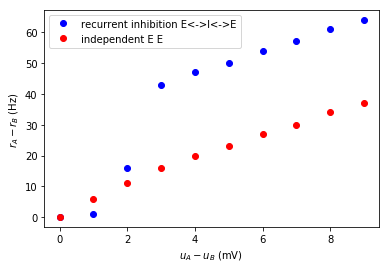

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

label='recurrent inhibition E<->I<->E'
spike_count_differences= [get_excitatory_spike_count_difference(result) for result in with_inhibitory_neuron]
ax.plot(drive_difference/mV, spike_count_differences/duration/hertz, 'bo', label=label)

label='independent E E'
spike_count_differences= [get_excitatory_spike_count_difference(result) for result in without_inhibitory_neuron]
ax.plot(drive_difference/mV, spike_count_differences/duration/hertz, 'ro', label=label)


ax.legend()
ax.set_xlabel("$u_A-u_B$ (mV) ")
ax.set_ylabel("$r_A-r_B$ (Hz) ");


In [13]:
def plot_spiking(result_dict):
    ex_spike_trains = result_dict["excitatory_spikes"]
    in_spike_trains = result_dict["inhibitory_spikes"]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, times in ex_spike_trains.items():
        ax.plot(times/ms, key/2.0*np.ones(times.shape), 'b|')

    offset=2
    for key, times in in_spike_trains.items():
        ax.plot(times/ms, (key+offset)/2.0*np.ones(times.shape), 'r|')

    
    ax.grid(axis='x')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time(ms)");

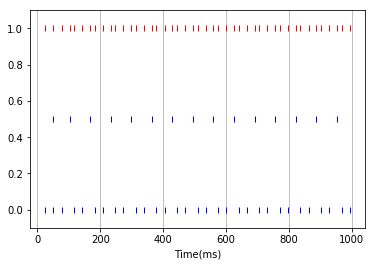

In [14]:
plot_spiking(with_inhibitory_neuron[2])


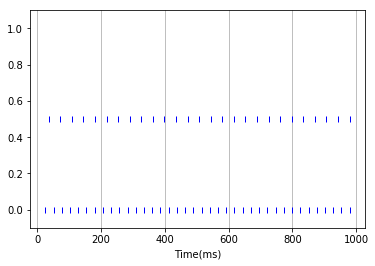

In [15]:
plot_spiking(without_inhibitory_neuron[2])


## Questions

- do I want/need noise
- do I need a refractory period to avoid the same suppression for the more active neuron -> seems to work without refractory period, but is less strong and not as nice
- do refractory periods affect spiking at all? only if flag (unless refractory) is given, https://brian2.readthedocs.io/en/stable/user/refractoriness.html
- what is the optimal interneuron to gate the output, that is which interneuron optimally supports decision mkaing in this microcircuit
- are there examples of such microcircuits for decision making?
- seems to be an interesting extension of the wang-buszaki model, because it takes timing into account, the non-linearity comes from timing
- is the strong timing a result of the pulse synapse?